# Quickstart


`AutoEmulate`'s goal is to make it easy to find a good emulator model for your simulation. Here's the basic workflow:

In [33]:
import numpy as np
import random
import torch
from autoemulate.compare import AutoEmulate
from autoemulate.experimental_design import LatinHypercube
from autoemulate.simulations.projectile import simulate_projectile

In [38]:
seed = 43 
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)

## Experimental design

Before we build an emulator or surrogate model, we need to get a set of input/output pairs from the simulation. This is called the **experimental design** and is currently not a key part of `AutoEmulate`, because this step is tricky to automate. There are lots of sampling techniques, but here we are using Latin Hypercube Sampling.   

Below, `simulator` is a simulation for a projectil motion with drag (see [here](https://mogp-emulator.readthedocs.io/en/latest/intro/tutorial.html) for details). It takes two inputs, the drag coefficient (on a log scale) and the velocity and outputs the distance the projectile travelled. We sample 100 sets of inputs `X` using a Latin Hypercube and run the simulator for those inputs to get the outputs `y`.

In [39]:
# sample from a simulation
lhd = LatinHypercube([(-5., 1.), (0., 1000.)]) # (upper, lower) bounds for each parameter
X = lhd.sample(100)
y = np.array([simulate_projectile(x) for x in X])
X.shape, y.shape

((100, 2), (100,))

## Compare emulator models using `AutoEmulate`

With a set of inputs / outputs, we can run `AutoEmulate` in just three lines of code. First, we initialise an `AutoEmulate` object. Then, we run `setup(X, y)`, providing the simulation inputs and outputs. Lastly, `compare()` will fit a range of different models to the data and evaluate them using cross-validation, returning the best emulator.

In [40]:
# compare emulator models
ae = AutoEmulate()
ae.setup(X, y)
ae.compare()

,Values
Simulation input shape (X),"(100, 2)"
Simulation output shape (y),"(100,)"
Proportion of data for testing (test_set_size),0.2
Scale input data (scale),True
Scaler (scaler),StandardScaler
Do hyperparameter search (param_search),False
Reduce dimensionality (reduce_dim),False
Cross validator (cross_validator),KFold
Parallel jobs (n_jobs),1


Initializing:   0%|          | 0/8 [00:00<?, ?it/s]

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', GaussianProcessTorch())])

## Cross-validation results

We can have a look at the average cross-validation results for each model:

In [43]:
ae.summarise_cv()

,model,short,rmse,r2
0,GaussianProcessTorch,gpt,417.572667,0.996850
1,RadialBasisFunctions,rbf,1123.863236,0.974527
2,ConditionalNeuralProcess,cnp,2573.645921,0.888730
3,GradientBoosting,gb,3003.408312,0.822223
4,SupportVectorMachines,svm,3173.087991,0.728889
5,SecondOrderPolynomial,sop,4016.512421,0.691743
6,RandomForest,rf,3186.803499,0.669745
7,LightGBM,lgbm,5531.439708,0.333302


Or create plots comparing the best fitting cv-folds for each model:

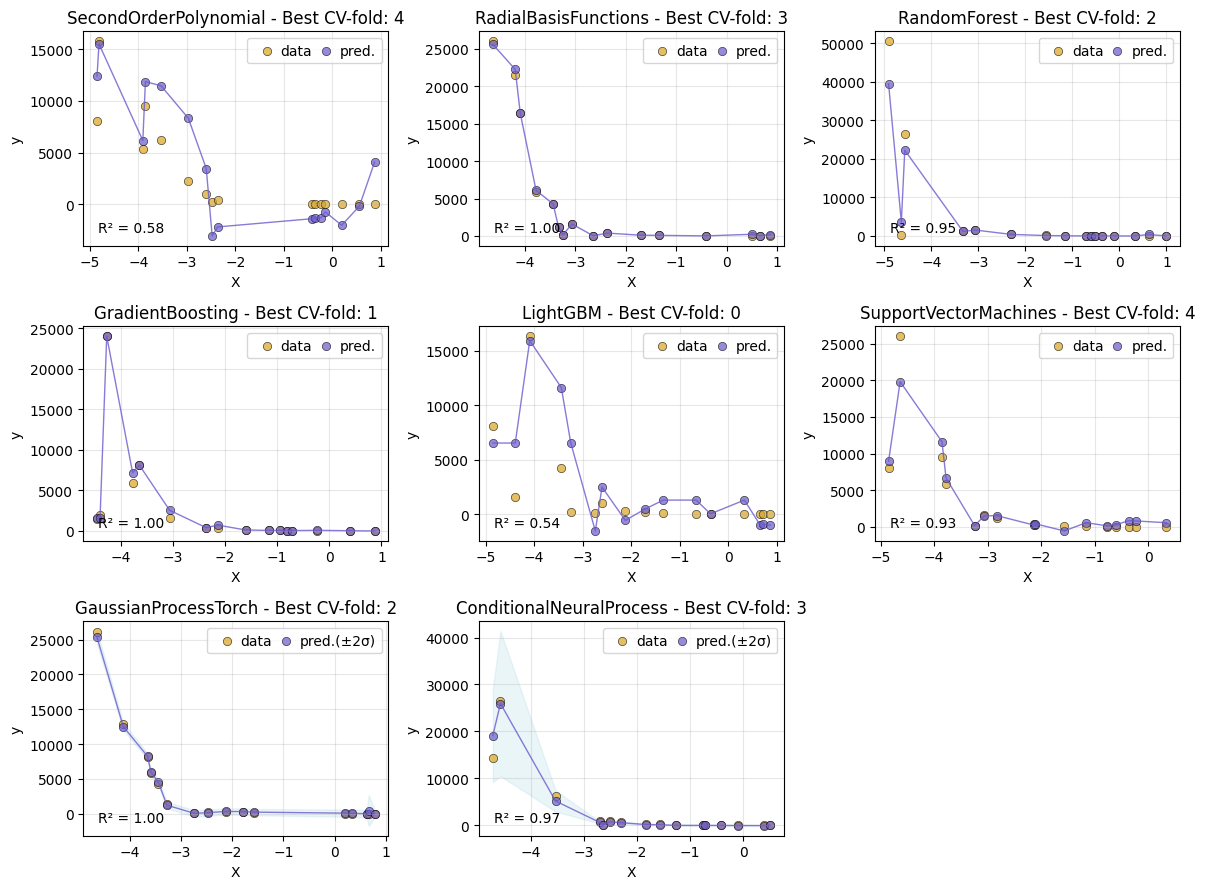

In [44]:
ae.plot_cv()

## Evaluating on the test set

`AutoEmulate` has already split the data into a training set and a test set. Let's retrieve a fitted emulator model and evaluate it on the test set.

In [45]:
gp = ae.get_model("GaussianProcessTorch")

We can see that the test set predictions for the Gaussian Process are pretty good here.

In [47]:
ae.evaluate(gp)

,model,short,target,rmse,r2
0,GaussianProcessTorch,gpt,target_0,81.789,0.9998


But it's always useful to plot the predictions too.

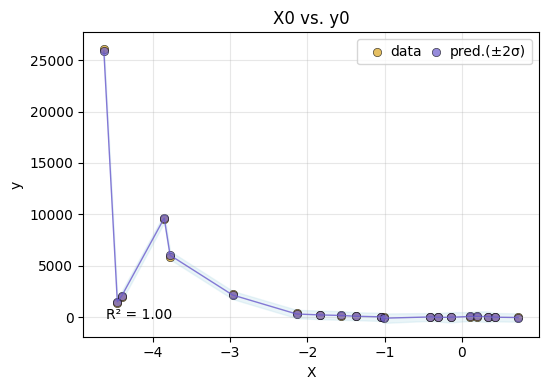

In [49]:
ae.plot_eval(gp)

## Refitting the model on the entire dataset

Before using the emulator model, we want to refit it on the entire dataset. This is done with the `refit()` method.

In [51]:
gp_final = ae.refit(gp)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', GaussianProcessTorch())])

## Making predictions

We can use the best model to make predictions for new inputs. Emulator models in `AutoEmulate` are `scikit-learn` estimators, so we can use the `predict` method to make predictions. 

In [58]:
## making predictions
gp_final.predict(X[:10])

array([5.98578957e+03, 8.03011039e+03, 1.65243572e+04, 8.19703199e+03,
       1.90421377e+02, 8.02669876e+00, 5.53836718e+01, 9.85207166e+01,
       1.08705910e+04, 1.13088652e+01])

## Saving / loading models

Lastly, we can save and load the best model. Note: to load a model, we need an initialised `AutoEmulate` object. This will ensure that the environment in which the model was saved is similar to the environment in which it is loaded.

In [ ]:
# save & load best model
# ae.save(best_emulator, "best_model")
# best_emulator = ae.load("best_model")